In [1212]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['figure.figsize'] = [20, 10]


In [1213]:
tracks_t = uproot.open("../test.root:diffusion output")
#tracks_t.values()

def weighted_avg_var(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    
    return (average, variance)

def prob_array(avg_track, z0, tol_distance=5):
    x_max=int(np.rint(max(avg_track[:,0]))) +1
    y_max=int(np.rint(max(avg_track[:,1]))) +1
    
    sub_array=np.empty((x_max,y_max))

    track_region=set()
    for i in range(0,x_max):
        for j in range(0,y_max):
        #print(i,j)
            int_charge=0
    
            for dep in avg_track:
                dist=np.sqrt((i-dep[0])**2 + (j-dep[1])**2)  
    
                diff_factor = 0.00323
                z_abs = z0 + 0.72 * 5 * dep[2] #0.72 microns/nanosecond
                sigma = diff_factor * np.sqrt(z_abs)
            
                if dist<=tol_distance:
                    track_region.add((i,j))
                    val = gauss_pixprob((i,j), dep, sigma) * dep[3]
                    int_charge+=val
            if int_charge<0.05:
                int_charge=np.nan
            sub_array[i,j]=int_charge
        
    return sub_array, np.array(list(track_region))
        
def gauss_pixprob(coord_pix,means,sig,norm=1,dp=0.1):
    #print(coord_pix)
    x_min=coord_pix[0]
    x_max=coord_pix[0]+1
    y_min=coord_pix[1]
    y_max=coord_pix[1]+1
    #print(x_min,x_max,y_min,y_max)
    x_range=np.arange(x_min,x_max,dp)
    y_range=np.arange(y_min,y_max,dp)
    
    xx,yy=np.meshgrid(x_range,y_range)
    
    return(np.sum(gauss_2d((xx,yy), means,sig))*dp * dp)

def gauss_2d(coord, means, sig,norm=1):
    x=coord[0]
    y=coord[1]
    return norm*(stats.norm.pdf(x, means[0], sig) * stats.norm.pdf(y,means[1], sig))

def calc_prob(track_dep, z0):
    diff_factor = 0.00323
    z_abs = z0 + 0.72 * 5 * track_dep[2] #0.72 microns/nanosecond
    sigma = diff_factor * np.sqrt(z_abs)
    
    origin = (track_dep[0], track_dep[1])
    charge = track_dep[3]
    
    x = np.arange(origin[0]-10, origin[0]+10, 0.1)#pixels
    y = np.arange(origin[1]-10, origin[1]+10, 0.1) #pixels #1 micron bins
    xx, yy = np.meshgrid(x,y)
    
    vals = gauss_2d((xx,yy), origin, sigma, charge)
    
    return(vals)

def diffuse(track_dep, z0):
    x=[]
    y=[]
    z=[]
    diff_factor = 0.00323
    z_abs = z0 + 0.72 * 5 * track_dep[2] #0.72 microns/nanosecond
    sigma = diff_factor * np.sqrt(z_abs)
    #print(track_dep[3])
    for c in range(int(track_dep[3])):
        x_new = np.random.normal(track_dep[0],sigma)
        y_new = np.random.normal(track_dep[1],sigma)
        x.append(x_new)
        y.append(y_new)
        z.append(z_abs)
    return np.array([x,y,z])

def label_nearby(deps,idx,track_idx):
    #deps is depositions
    #given a track_id, identify all pixels with track_id and then label all pixels touching track_id
    
    found=False
    locs=[]
    for start_pix in deps[np.argwhere(track_idx==idx)]:
        #print(start_pix)
        i_start=start_pix[0][0]
        j_start=start_pix[0][1]
        z_start=start_pix[0][2]
        
        for i, pixel in enumerate(deps):
            
            i_check=pixel[0]
            j_check=pixel[1]
            z_check=pixel[2]
            
            if (not np.isnan(track_idx[i])):
                continue
            #print(start_pix, pixel, diff[i-1])
            #print(np.abs(z_start-z_check))
            if(np.abs(z_start-z_check)<=2):
                dist=np.sqrt((i_check-i_start)**2 + (j_check-j_start)**2)
                if(dist<2):
                    found=True
                    track_idx[i]=idx+1
                    locs.append(i)
    branch_check = deps[np.argwhere(track_idx==idx+1)]
    #print(locs)
    x = branch_check[:,0][:,0]
    y = branch_check[:,0][:,1]
    new_branch=[np.argwhere(track_idx==idx+1)][0]
    if (np.var(x) + np.var(y) >5):
        #print('branch found', max(np.diff(x)), max(np.diff(y)))
        max_loc = (np.argwhere(np.diff(y) == max(np.diff(y))))
        #find largest diff in x and y
        y0 = min(y)
        y1 = max(y)
        x0 = min(x)
        x1 = max(x)
        #print(y0,y1)
        for i, val in enumerate(branch_check[:,0]):
            if np.abs(val[0]-x0) >=3 or np.abs(val[1]-y0) >=3:
                track_idx[new_branch[i]] = idx+1000
    
    if (not found):
        #move on with next nan value
        loc=np.min(np.argwhere(np.isnan(track_idx)))
        track_idx[loc] = idx+1
        
    return track_idx
def label_track(deps):
    #label all depositions with track ids
    track_idx=np.empty(len(deps))
    track_idx[:]=np.nan
    track_idx[0]=0
    idx=0
    while(np.isnan(np.sum(track_idx))):
        track_idx=label_nearby(deps, idx, track_idx)
          
        idx +=1
    return track_idx


def average_track(track_ids, deps, charge):
    avg_pixels=[]
    var=[]
    for pix_id in range(int(max(track_ids)+1)):

        locs = (np.argwhere(track_ids==pix_id))
        if(len(locs)==0):
            continue
        pixels = deps[locs][:,0]
        var.append(np.var(pixels[:,0] + np.var(pixels[:,1])))
        x_avg, x_var= weighted_avg_var(pixels[:,0], weights = charge[locs][:,0])
        
        #np.average(pixels[:,0], weights=charge[locs][:,0])
        y_avg=np.average(pixels[:,1], weights=charge[locs][:,0])
        z_avg=np.average(pixels[:,2], weights=charge[locs][:,0])
        charge_sum = np.sum(charge[locs])
        #print(var[-1],z_avg)
        avg_pixels.append([x_avg,y_avg,z_avg, charge_sum])
    
    avg_pixels=np.array(avg_pixels)
    
    return avg_pixels,var

In [1216]:
event_num = 0 #good ones: 0,2,6,13,14,9,15,11 sorta:5,10,11 bad:18(need to investigate this one), 4,1,8
x_pix = tracks_t["x_pix"].array()[event_num]
y_pix = tracks_t["y_pix"].array()[event_num]
c_dep = tracks_t["depC_pix"].array()[event_num]
z_toa = tracks_t["z_toa"].array()[event_num]
mean_z = tracks_t["mean_z"].array()[event_num]
z_toa = z_toa - min(z_toa)+1
print(np.sum(c_dep))
binsx=np.arange(-1,np.max(x_pix)+1,1)
binsy=np.arange(-1,np.max(y_pix)+1,1)
binsx

259787


array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124])

Method: set start pixel idx to 0, set all touching pixels idx to 1 and repeat
then average numbers


1 1
1083.2501220703125
259787.0


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125])

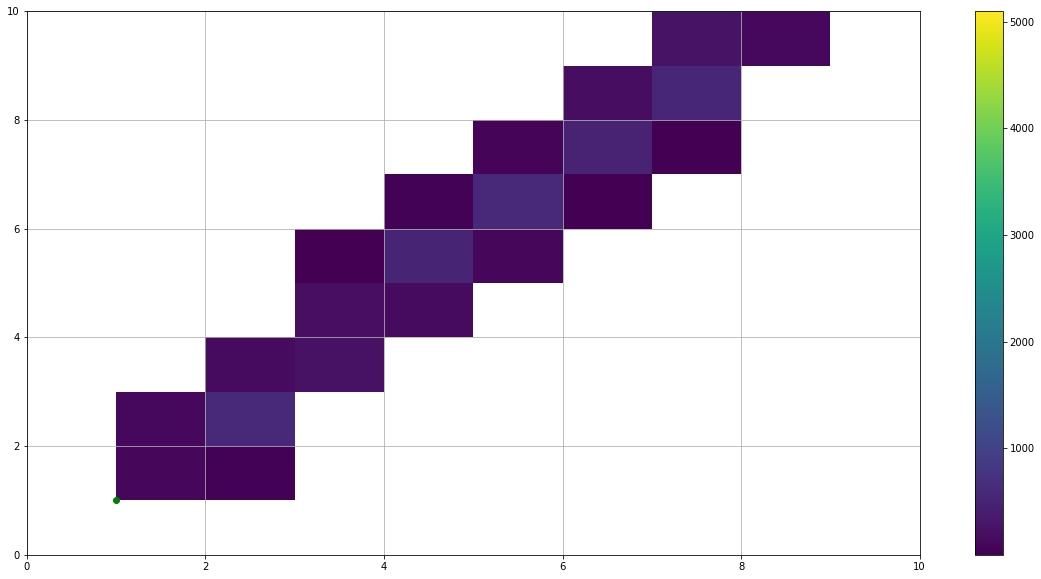

In [1217]:
pix, xedges, yedges, image = plt.hist2d(x_pix, y_pix, (binsx+1, binsy+1), cmin=0.01, weights=c_dep)
#plt.xticks(binsx)
#plt.plot(locs[0],locs[1], 'go')
plt.plot(x_pix[0], y_pix[0],'go')
print(x_pix[0], y_pix[0])
plt.colorbar()
plt.xlim((0,10))
plt.ylim((0,10))
print(mean_z)
plt.grid()
print(np.nansum(pix))
xedges

In [1188]:
pix_array=pix

In [1189]:
deps=np.dstack((np.array(x_pix),np.array(y_pix),np.array(z_toa)))[0]
track_idx=np.empty(len(deps))
track_idx[:]=np.nan
track_idx[0]=0
idx=0
track_id=label_track(deps)

In [1218]:
avg_track ,var=average_track(track_id, deps, c_dep)

1045


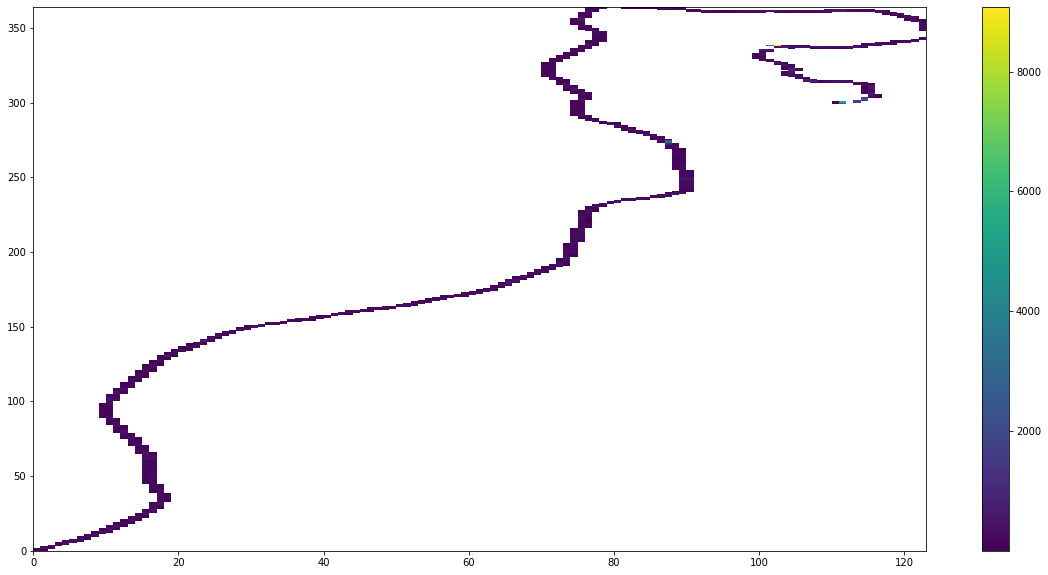

In [751]:
x_new=[]
y_new=[]
#z=[]
for val in avg_track:
    z0=1000#um
    x,y,z=diffuse(val, z0)
    x_new.extend(x)
    y_new.extend(y)
    
pix, xedges, yedges, image = plt.hist2d(x_new, y_new, (binsx, binsy),cmin=0.1)
plt.colorbar()
print(np.count_nonzero(~np.isnan(pix)))

#plt.xlim((0,10))
#plt.ylim((0,10))

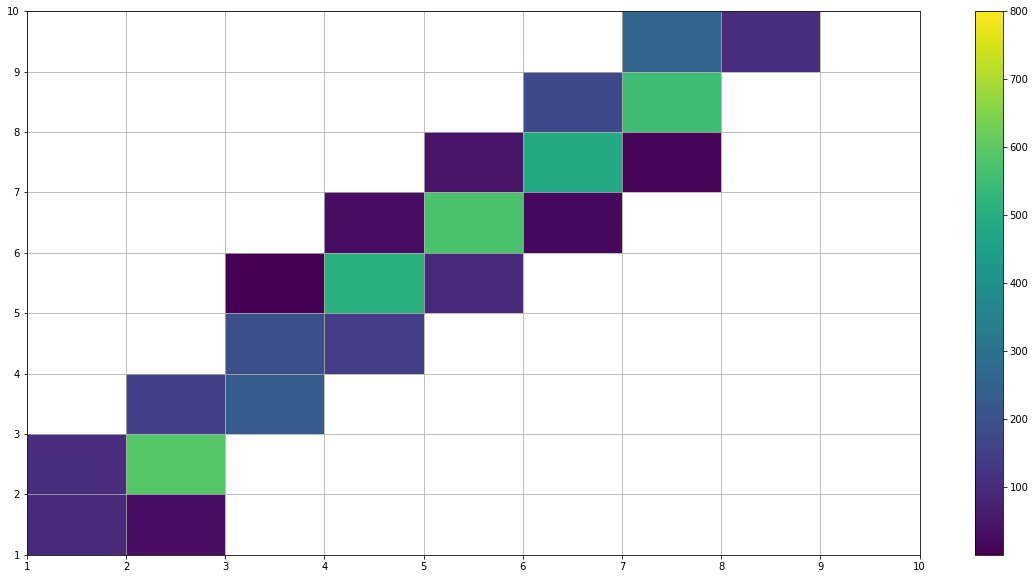

In [1181]:
pix, xedges, yedges, image = plt.hist2d(x_pix, y_pix, (binsx,binsy) ,cmin=0.01, weights=c_dep, vmax=800)
plt.colorbar()
plt.xticks(binsx)
plt.yticks(binsy)
plt.xlim((1,10))
plt.ylim((1,10))
plt.grid()

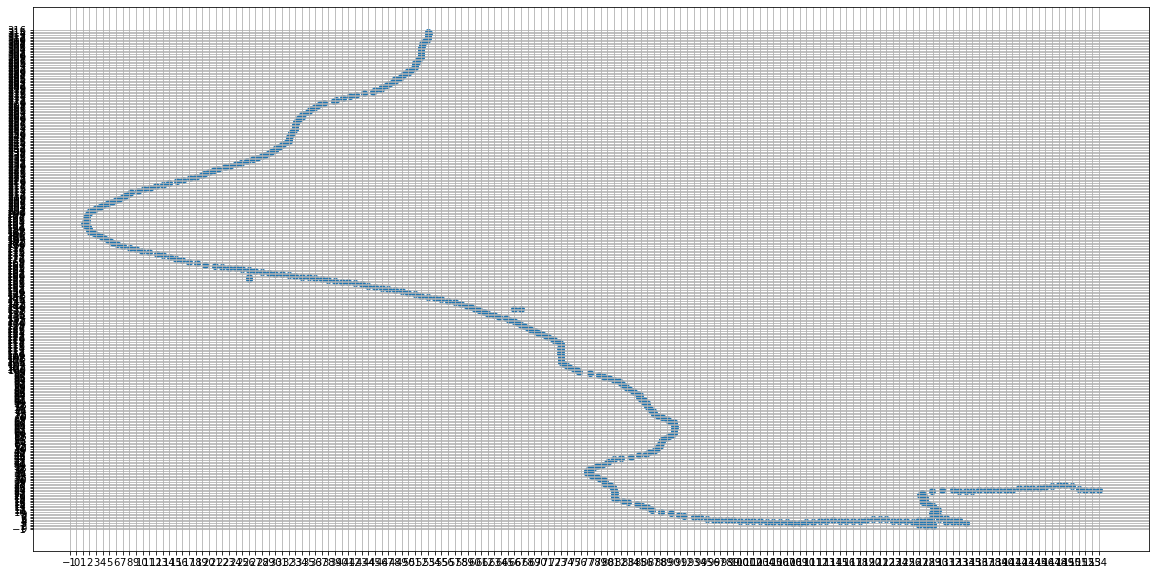

In [920]:
plt.scatter(avg_track[:,0],avg_track[:,1])
plt.xticks(binsx)
plt.yticks(binsy)
#plt.xlim((0,10))
#plt.ylim((0,10))
plt.grid()

In [708]:
# want to calculate the expected amount of charge for a given pixel given a z and a deconvolved track
#say we are at pixel i,j = 0,0
#there is a given range for which depositions might deposit charge at that pixel (ie dont want to scan all depositions)
#say that number is 10 pixels (probably large)
#we then look at depositions within i+/-10, j+/10 (100 pixels, probably large)
#check maxes
#check for depositions within region

x_max=125
y_max=370
sub_array=np.empty((x_max,y_max))
#nt_charge=0
#print(sub_array)
print((pix[0:10,0:10]))
z0=1000
for i in range(0,x_max):
    for j in range(0,y_max):
        #print(i,j)
        int_charge=0
    
        for dep in avg_track:
            dist=np.sqrt((i-dep[0])**2 + (j-dep[1])**2)  
    
            diff_factor = 0.00323
            z_abs = z0 + 0.72 * 5 * dep[2] #0.72 microns/nanosecond
            sigma = diff_factor * np.sqrt(z_abs)
            
            if dist<=5:
                val = gauss_pixprob((i,j), dep, sigma) * dep[3]
                int_charge+=val
        #print(int_charge)
        if int_charge<0.05:
            int_charge=np.nan
        #print(int_charge)
        sub_array[i,j]=int_charge
        
#print(np.nansum(sub_array))        

[[nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]]


KeyboardInterrupt: 

In [1170]:
test, coords=prob_array(avg_track,1000)

259786.41968057276
33026


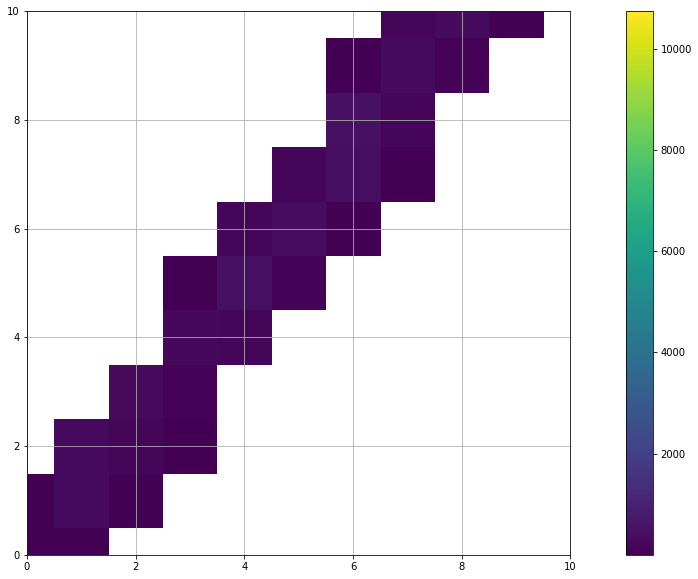

In [1171]:
plt.imshow(test.T,origin="lower")
plt.colorbar()
print(np.nansum(test))
#print(max(sub_array.flatten()))
plt.xlim((0,10))
plt.ylim((0,10))
plt.grid()
print(np.count_nonzero(~np.isnan(sub_array)))

In [1211]:
print(np.nansum(stats.poisson.pmf(pix.flatten(), test.flatten())))

print(pix.flatten()[:40])
print(test.flatten()[:40])
min(coords[0])

3.0507672661410004
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
[ 9.87303027 20.75274116         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan]


60

In [1024]:
z_deps = np.arange(0,5000,500)
l=[]

for z0 in z_deps:
    test, coords=prob_array(avg_track,z0)
    l.append(np.nansum(stats.poisson.pmf(pix[coords[:,0], coords[:,1]], test[coords[:,0], coords[:,1]])))



KeyboardInterrupt: 

In [ ]:
plt.plot(z_deps,l)
mean_z

In [1257]:
var=[]
z=[]
num_deps=[]
z_avg=[]
test=[]
for event in range(0,30):
    print(event)
    event_num = event
    x_pix = tracks_t["x_pix"].array()[event_num]
    y_pix = tracks_t["y_pix"].array()[event_num]
    c_dep = tracks_t["depC_pix"].array()[event_num]
    z_toa = tracks_t["z_toa"].array()[event_num]
    mean_z = tracks_t["mean_z"].array()[event_num]
    z_toa = z_toa - min(z_toa)+1
    num_deps.append(len(x_pix))
    z_avg.append(mean_z)
    deps=np.dstack((np.array(x_pix),np.array(y_pix),np.array(z_toa)))[0]
    
    track_idx=np.empty(len(deps))
    track_idx[:]=np.nan
    track_idx[0]=0
    idx=0
    track_id=label_track(deps)
    
    try:
        avg_track, variance=average_track(track_id, deps, c_dep)
        var.append((variance))
        test.append(np.mean(variance))
        z.append(mean_z)
        #num_deps.append(len(variances))
        #z_avg.append(mean_z)
    except:
        continue
    

0
1


/opt/homebrew/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


/opt/homebrew/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


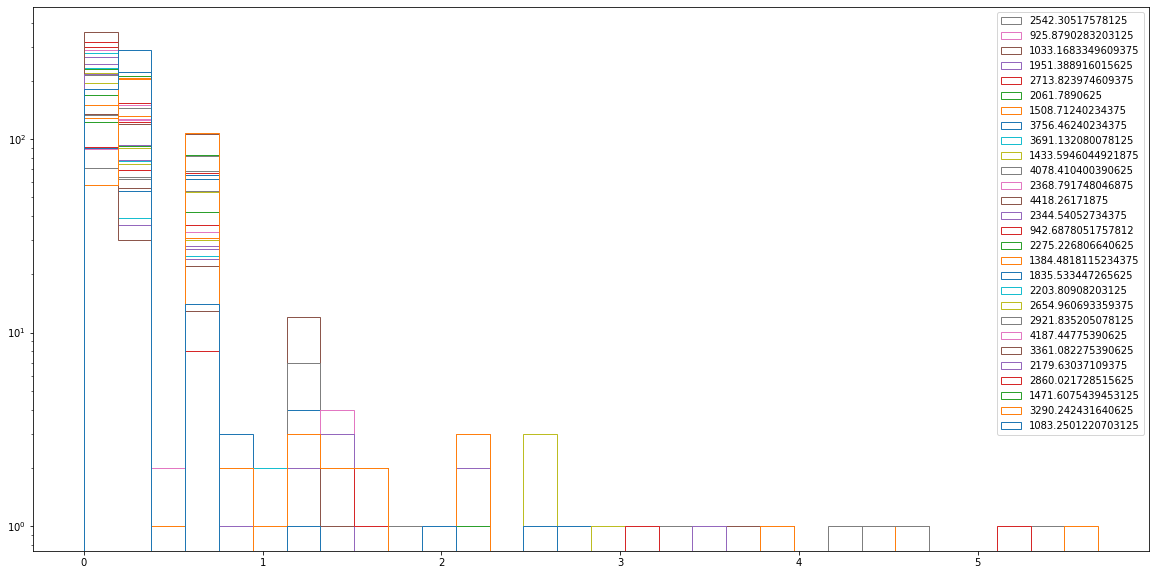

In [1260]:
plt.hist(var[:2, 30,label=z, histtype='step')
plt.yscale('log')
plt.legend()
mean_dist=np.mean(var)



Text(0.5, 0, 'var_xy')

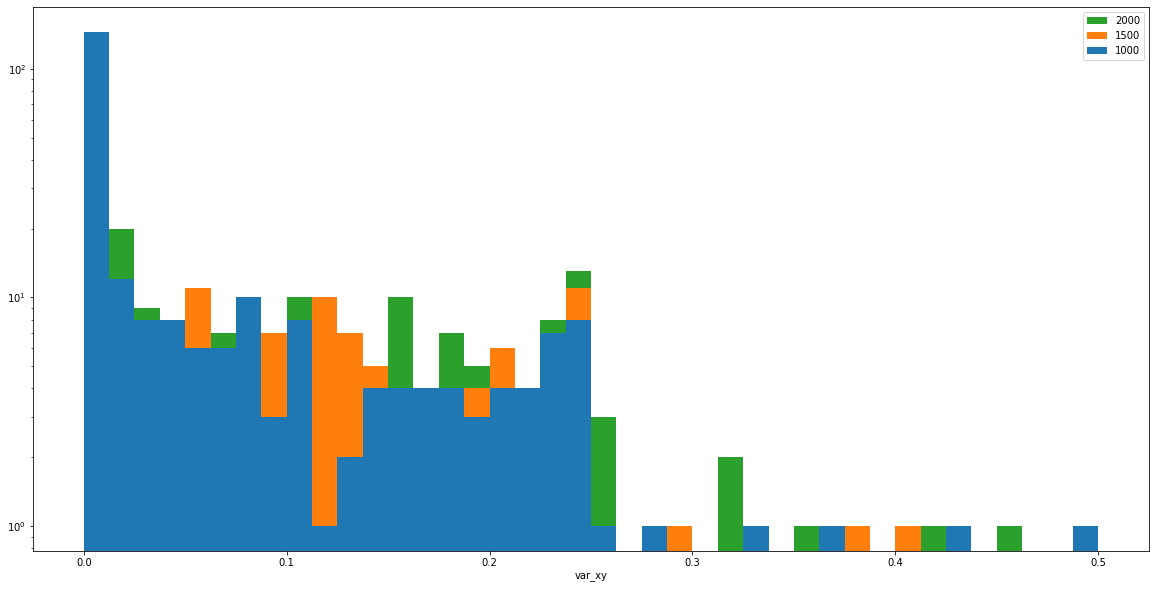

In [1208]:
plt.hist(xyvar[:3],40, label=z_dep[:3], histtype='stepfilled')
plt.yscale('log')
plt.legend()
plt.xlabel("var_xy")

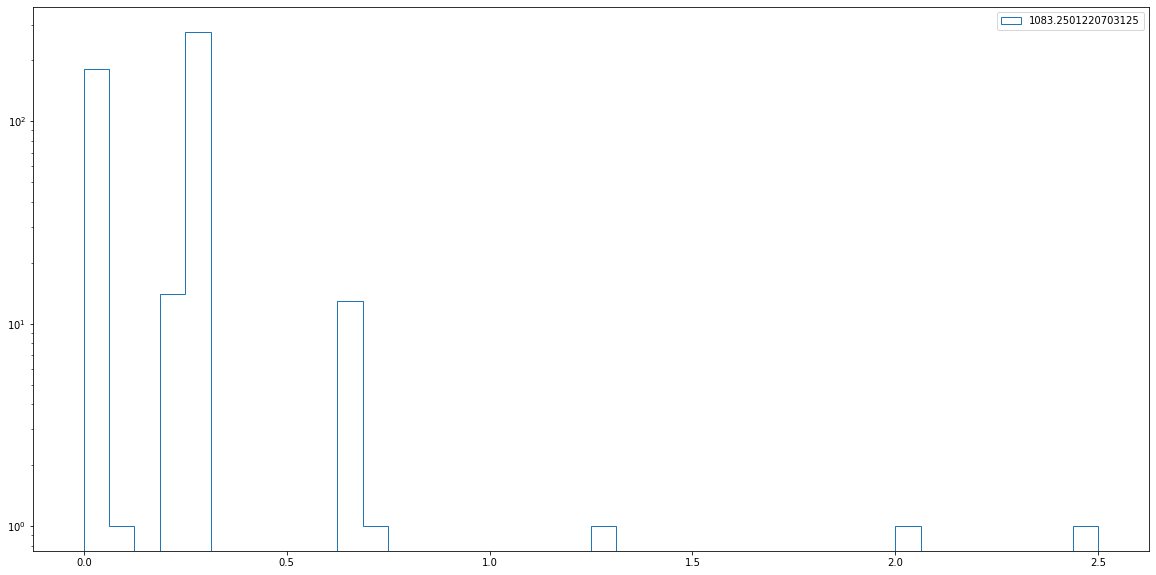

In [1209]:
plt.hist(var, 40,label=z,histtype='step')
plt.legend()
plt.yscale('log')